## GCN - Transductive Link Prediction using joint representation

In [15]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import init
from random import shuffle, randint
import torch.nn.functional as F
from torch_geometric.datasets import Reddit, PPI, Planetoid
from itertools import combinations, combinations_with_replacement
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from torch_geometric.data import NeighborSampler
import matplotlib.pyplot as plt
import sys
import time


## Define and load the dataset

In [16]:
DATASET = 'cora'
RUN_COUNT = 1
PATH_TO_DATASETS_DIRECTORY = './'

In [17]:
datasets = {
    'reddit': Reddit(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Reddit'),
    'cora' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Cora/', name='Cora'),
    'citeseer' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/CiteSeer/', name='CiteSeer'),
    'pubmed' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/PubMed/', name='PubMed'),
}
dataset = datasets[DATASET]
data = dataset[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [18]:
print("Printing Dataset Characteristics")
print("Name: ", DATASET)
print("Total Number of Nodes: ", data.num_nodes)
print("Total Number of Training Nodes: ", data.train_mask.sum().item())
print("Total Number of Val Nodes: ", data.val_mask.sum().item())
print("Total Number of Test Nodes: ", data.test_mask.sum().item())
print("Num Node Features: ", data.num_features)
print("Num Node Classes: ", dataset.num_classes)
print("Number of Edges: ", data.edge_index.shape[1])

Printing Dataset Characteristics
Name:  cora
Total Number of Nodes:  2708
Total Number of Training Nodes:  140
Total Number of Val Nodes:  500
Total Number of Test Nodes:  1000
Num Node Features:  1433
Num Node Classes:  7
Number of Edges:  10556


## Sample edges to create train, val and test links

In [19]:
import sys
from torch_geometric.data import Data


def sample_edges(data,train_percent, val_percent, test_percent):
    edges = data.edge_index.t()
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    adj_mat[edges[:,0], edges[:,1]] = 1
    
    true_edges=adj_mat.triu().nonzero()
    num_edges=true_edges.shape[0]
    
    inverse_adj_mat = 1 - adj_mat
    non_edges = inverse_adj_mat.triu().nonzero()
    
    num_non_edges  = non_edges.shape[0]
    
    total_samples= int(num_edges * np.minimum(train_percent+val_percent+test_percent,1.0))
    
    edges_sampled = edges[np.random.randint(num_edges, size=total_samples)]
    non_edges_sampled = non_edges[np.random.randint(num_non_edges, size=total_samples)]
    
    #Remove sampled edges from the graph
    
    adj_mat[edges_sampled[:,0],edges_sampled[:,1]]=0
    adj_mat[edges_sampled[:,1],edges_sampled[:,0]]=0
    adj_mat[non_edges_sampled[:,0],non_edges_sampled[:,1]]=0
    adj_mat[non_edges_sampled[:,1],non_edges_sampled[:,0]]=0
    
    n_test_percent=test_percent/(train_percent+val_percent+test_percent)
    n_val_percent=val_percent/(train_percent+val_percent+test_percent)
    n_train_percent=train_percent/(train_percent+val_percent+test_percent)
    
    test_size=int(n_test_percent*total_samples)
    val_size=int(n_val_percent*total_samples)    
    
    x_test_pos=edges_sampled[0:test_size]
    x_val_pos=edges_sampled[test_size:test_size+val_size]
    x_train_pos=edges_sampled[test_size+val_size:]
    
    x_test_neg=non_edges_sampled[0:test_size]
    x_val_neg=non_edges_sampled[test_size:test_size+val_size]
    x_train_neg=non_edges_sampled[test_size+val_size:]
    
    
    total=len(x_test_pos)+len(x_val_pos)+len(x_train_pos)
    print("Positive: ",total_samples, len(x_train_pos), len(x_val_pos), len(x_test_pos), total )
    
    non_total=len(x_test_neg)+len(x_val_neg)+len(x_train_neg)
    print("Negative: ",total_samples, len(x_train_neg), len(x_val_neg), len(x_test_neg), non_total )
    
    edges=adj_mat.nonzero()
    edge_weight=torch.ones((len(edges)))
    
    y_train_pos=torch.ones((len(x_train_pos)))
    y_val_pos=torch.ones((len(x_val_pos)))
    y_test_pos=torch.ones((len(x_test_pos)))
    
    y_train_neg=torch.zeros((len(x_train_neg)))
    y_val_neg=torch.zeros((len(x_val_neg)))
    y_test_neg=torch.zeros((len(x_test_neg)))
    
        
    G_data=Data(edge_index=edges.t(), edge_weight=edge_weight, x=data.x)
    
    return G_data, x_train_pos, y_train_pos,  x_train_neg, y_train_neg, x_val_pos, y_val_pos,  x_val_neg, y_val_neg, x_test_pos, y_test_pos,  x_test_neg, y_test_neg
    
    
    

## Create train test validation set

In [20]:
G_data, x_train_pos, y_train_pos,  x_train_neg, y_train_neg, x_val_pos, y_val_pos,  x_val_neg, y_val_neg, x_test_pos, y_test_pos,  x_test_neg, y_test_neg=sample_edges(data,0.10,0.10,0.10)

print(data)
print(G_data)

x_train = torch.cat((x_train_pos,x_train_neg),dim=0).type(torch.long).to(device)
y_train = torch.cat((y_train_pos,y_train_neg),dim=0).type(torch.long).to(device)

x_val = torch.cat((x_val_pos,x_val_neg),dim=0).type(torch.long).to(device)
y_val = torch.cat((y_val_pos,y_val_neg),dim=0).type(torch.long).to(device)

x_test = torch.cat((x_test_pos,x_test_neg),dim=0).type(torch.long).to(device)
y_test = torch.cat((y_test_pos,y_test_neg),dim=0).type(torch.long).to(device)


Positive:  1583 529 527 527 1583
Negative:  1583 529 527 527 1583
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Data(edge_index=[2, 7948], edge_weight=[7948], x=[2708, 1433])


## Define the GNN Network

In [21]:
num_neurons = 50
input_rep = data.num_features

from torch_geometric.nn import GCNConv,GATConv,SAGEConv, GINConv
GNNlayer=GCNConv

class JointGNN(nn.Module):
    def __init__(self):
        super(JointGNN, self).__init__()
        
        self.GNN_layer1 = GNNlayer(input_rep,num_neurons)
        self.GNN_layer2 = GNNlayer(num_neurons,num_neurons)
        
        self.linear1 = nn.Linear(num_neurons,num_neurons)
        self.linear2 = nn.Linear(num_neurons,2)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x_feature, subgraphs, nodes, edges):
        
        
        node_tensor = torch.zeros((len(nodes), num_neurons)).to(device)
        node_count = torch.zeros((len(nodes)),requires_grad=False).to(device)

        
        for i in range(len(subgraphs)):
        
            graph=subgraphs[i]
            
            x=x_feature[i]
            x=self.GNN_layer1(x,graph.edge_index, graph.edge_weight)
            x=self.relu(x)
            
            x=self.GNN_layer2(x,graph.edge_index, graph.edge_weight)
            x=self.relu(x)
            
            for n_id in graph.b_id:                            
                sub_index=(graph.n_id==n_id).nonzero()[0]
                sub_x=x[sub_index,:]
                
                node_index=(nodes==n_id).nonzero()[0]
                
                node_count[node_index]+=1
                node_tensor[node_index,:]+=sub_x.view(-1)
        
        node_tensor=node_tensor / node_count[:, None]
        
        z_tensor = torch.zeros((len(edges), num_neurons)).to(device)
        
        link_no=0
        for edge in edges:
            u=(nodes==edge[0]).nonzero()[0]
            v=(nodes==edge[1]).nonzero()[0]
            
            z_tensor[link_no,:]=(node_tensor[u,:]*node_tensor[v,:]).view(-1)
            link_no+=1
        
        #One Hidden Layer for predictor
        z_tensor = self.linear1(z_tensor)
        z_tensor = self.relu(z_tensor)
        z_tensor = self.linear2(z_tensor)
        
        return z_tensor

    def compute_loss(self, x_feature, subgraphs, nodes, edges, target):
        
        pred = self.forward(x_feature, subgraphs, nodes, edges)
        
        return F.cross_entropy(pred, target)
    
    def predict(self, x_feature, subgraphs, nodes, edges, target):
        
        pred = self.forward(x_feature, subgraphs, nodes, edges)        
        loss = F.cross_entropy(pred, target)
        
        return loss, pred
        
        

## Edge Batch Loader

In [22]:
import logging

class MiniBatcher(object):
    def __init__(self, batch_size, n_examples, shuffle=True):
        assert batch_size <= n_examples, "Error: batch_size is larger than n_examples"
        self.batch_size = batch_size
        self.n_examples = n_examples
        self.shuffle = shuffle
        logging.info("batch_size={}, n_examples={}".format(batch_size, n_examples))

        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0

    def get_one_batch(self):
        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0
        while self.current_start < self.n_examples:
            batch_idxs = self.idxs[self.current_start:self.current_start+self.batch_size]
            self.current_start += self.batch_size
            yield torch.LongTensor(batch_idxs)

## Prediction 

In [23]:
def predict_model(model,G_data, x_data, y_data, minibatch_size, neighbor_sampler):
    
    batcher = MiniBatcher(minibatch_size, len(x_data)) if minibatch_size > 0 else MiniBatcher(len(x_data), len(x_data))
    
    preds=np.array([])
    targets=np.array([])
    total_loss=0
    
    with torch.no_grad():
        for x_idxs in batcher.get_one_batch():
            x_idxs = x_idxs.to(device)

            x_edges=x_data[x_idxs]
            target=y_data[x_idxs]

            nodes=torch.flatten(x_edges)
            
            neighbor_graph=neighbor_sampler(nodes.cpu())
        
            x_feature=[]
            subgraphs=[]

            for graph in neighbor_graph:

                sub_nodes=graph.n_id
                sub_edges=graph.e_id
                graph["edge_weight"]=G_data.edge_weight[sub_edges]            
            
                x_feature.append(torch.Tensor(G_data.x[sub_nodes]).to(device))
                subgraphs.append(graph.to(device))

            loss, pred=model.predict(x_feature, subgraphs, nodes, x_edges, target)                          
            total_loss+=loss.item()
            
            pred = F.log_softmax(pred, dim=1)
            pred = pred.detach().to("cpu").numpy()
            pred = np.argmax(pred, axis=1)
                          
            preds = np.append(preds,pred)
            targets = np.append(targets,target.detach().to("cpu").numpy())
    
    micro=f1_score(targets, preds, average='micro')
    weighted=f1_score(targets, preds, average='weighted')
    acc=accuracy_score(targets, preds)
    
    
    return total_loss, acc, micro, weighted

## Show and save Plots

In [24]:
def save_plot(train_data, valid_data, name='Loss'):
    """Plot
        Plot one figure: accurace/loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_data)
    xs = np.arange(n)

    # plot train and test accuracies
    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_data, '--', linewidth=2, label='train')
    ax.plot(xs, valid_data, '-', linewidth=2, label='valid')
    ax.set_xlabel("Epoch")
    ax.set_ylabel(name)
    ax.legend(loc='lower right')
    plt.show()
    plt.savefig('train_valid_'+name+'.png')
    

## Define the Model and Train the network

JointGNN(
  (GNN_layer1): GCNConv(1433, 50)
  (GNN_layer2): GCNConv(50, 50)
  (linear1): Linear(in_features=50, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Minibatch time:  7.434285640716553
Saving model Validation Accuracy:  0.6043643263757116
----------------------------------------------------------------------------------------------------
[Epoch 0] Train Loss: 342.1237107217312, Train Accuracy: 0.6965973534971645, Val Loss 348.9912263453007, Val Accuracy: 0.6043643263757116
Minibatch time:  7.313271999359131
Saving model Validation Accuracy:  0.650853889943074
----------------------------------------------------------------------------------------------------
[Epoch 1] Train Loss: 249.64581272006035, Train Accuracy: 0.8147448015122873, Val Loss 340.79165364801884, Val Accuracy: 0.650853889943074
Minibatch time:  7.257330894470215
Saving model Validation Accuracy:  0.715370018975332
-----------

<Figure size 432x288 with 0 Axes>

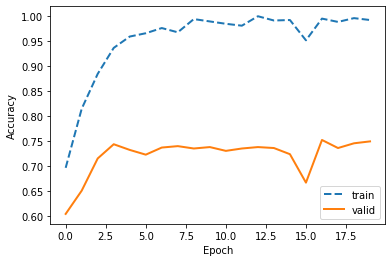

<Figure size 432x288 with 0 Axes>

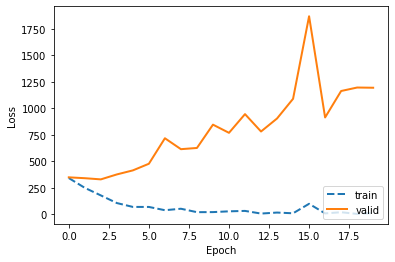

<Figure size 432x288 with 0 Axes>

In [25]:
gnn_model = JointGNN().to(device)
gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
gnn_best_model = 'best_gnn_model.model'

print(gnn_model)

epochs = 20
validation_acc = 0
minibatch_size=2

train_batcher = MiniBatcher(minibatch_size, len(x_train)) if minibatch_size > 0 else MiniBatcher(len(x_train), len(x_train))

k=5
hop=2

neighbor_sampler=NeighborSampler(G_data,size=k,num_hops=hop,bipartite=False,batch_size=2*minibatch_size)

train_accs=[]
val_accs=[]
train_losses=[]
val_losses=[]

for num_epoch in range(epochs):
    
    #Training phase                      
    t_start = time.time()
    for train_idxs in train_batcher.get_one_batch():
        train_idxs = train_idxs.to(device)
        
        train_edges=x_train[train_idxs]
        target=y_train[train_idxs]

        nodes=torch.flatten(train_edges)
        neighbor_graph=neighbor_sampler(nodes.cpu())
        
        x_feature=[]
        subgraphs=[]
        
        for graph in neighbor_graph:
                
            sub_nodes=graph.n_id
            sub_edges=graph.e_id
            
            graph["edge_weight"]=G_data.edge_weight[sub_edges]            
            
            x_feature.append(torch.Tensor(G_data.x[sub_nodes]).to(device))
            subgraphs.append(graph.to(device))
        
        
        gnn_optimizer.zero_grad()        
        
        loss=gnn_model.compute_loss(x_feature, subgraphs, nodes, train_edges, target)
        #print(loss)
        
        loss.backward()
        gnn_optimizer.step()
    
    t_end= time.time()
    print("Minibatch time: ",t_end-t_start)
    
    train_loss,train_acc,_,_=predict_model(gnn_model,G_data, x_train, y_train, minibatch_size, neighbor_sampler)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss,val_acc,_,_=predict_model(gnn_model,G_data, x_val, y_val, minibatch_size, neighbor_sampler)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > validation_acc:
            validation_acc = val_acc
            print("Saving model Validation Accuracy: ", validation_acc)
            #Save Model
            torch.save(gnn_model.state_dict(), gnn_best_model)
    
    print("-"*100)
    print("[Epoch {0}] Train Loss: {1}, Train Accuracy: {2}, Val Loss {3}, Val Accuracy: {4}".format(num_epoch, train_loss, train_acc, val_loss, val_acc))
    

    
save_plot(train_accs, val_accs, name='Accuracy')
save_plot(train_losses, val_losses, name='Loss')



## Load the best model,  Forward pass on the test graphs

In [26]:
gnn_best_model = 'best_gnn_model.model'
gnn_model = JointGNN().to(device)
gnn_model.load_state_dict(torch.load(gnn_best_model))

test_loss,test_acc,test_micro,test_weighted=predict_model(gnn_model,G_data, x_test, y_test, minibatch_size, neighbor_sampler)

print("Test Micro F1 Score: ", test_micro)
print("Test Weighted F1 Score: ", test_weighted)
print("Test Accuracy Score: ", test_acc)

Test Micro F1 Score:  0.7333965844402277
Test Weighted F1 Score:  0.7329521120004472
Test Accuracy Score:  0.7333965844402277


## Scratch

In [27]:
# from torch_geometric.data import NeighborSampler

# print(G_data)

        
# k=5
# hop=2


# neighbor_sampler=NeighborSampler(G_data,size=k,num_hops=hop,bipartite=False,batch_size=2)

# for j in range(1):
    
#     print("="*100)
    
#     n_id=torch.Tensor([1,2,3,4,5,6]).type(torch.long)

#     for i in neighbor_sampler(n_id):
#         i["sid"]=1
        
#         print(i)
#         print(i.edge_index)
#         print(i.n_id)
#         print(i.e_id)
#         print(i.b_id)
#         print(i.sub_b_id)
        
        
        
#     print("="*100)

# nodes=torch.Tensor([1,2,3])

# res = dict(zip(nodes, torch.arange(0,len(nodes)).type(torch.long)))

# print(res)

# (nodes==2).nonzero()[0]

#nodes=torch.Tensor([[1,2,3],[4,5,6]])
#counts=torch.Tensor([1,2])

#print(nodes / counts[:, None])

# edges=torch.Tensor([[1,2],[4,5]])


# for edge in edges:
#     print(edge)
